# İsmail Avcu

## 1 - Preparing Dataset

### a - Download

In [1]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import tree
from sklearn import metrics #for accuracy calculation
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()

In [3]:
 !mkdir ~/.kaggle
 !cp kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download -d gauravtopre/bank-customer-churn-dataset
!unzip /content/bank-customer-churn-dataset.zip -d data

bank-customer-churn-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/bank-customer-churn-dataset.zip
replace data/Bank Customer Churn Prediction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
!ls
print()
!ls data

 bank-customer-churn-dataset.zip  'kaggle (1).json'   sample_data
 data				   kaggle.json

'Bank Customer Churn Prediction.csv'


In [6]:
df = pd.read_csv("/content/data/Bank Customer Churn Prediction.csv")
print(df.head())
print()
print("Total sample count: ", len(df))

   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  

Total sample count:  10000


In [7]:
counter_object = Counter(df["churn"])
print(counter_object)

Counter({0: 7963, 1: 2037})


Unbalanced Dataset must be Balanced.

In [8]:
df_balanced = pd.DataFrame()
df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1 = df[df["churn"] == 1]
df2 = df.loc[df["churn"].isin([0])].groupby("churn").head(2037)


data = [df1, df2]

df_balanced = pd.concat(data)

del df1
del df2
del data

In [9]:
counter_object = Counter(df_balanced["churn"])
print(counter_object)

Counter({1: 2037, 0: 2037})


### b - Getting Rid of Useless Features such as id

In [10]:
df_balanced

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
16,15737452,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2585,15612030,724,France,Male,28,9,0.00,2,1,1,100240.20,0
2586,15573242,691,France,Male,50,6,136953.47,1,1,1,2704.98,0
2587,15601892,563,France,Male,33,8,0.00,2,0,1,68815.05,0
2588,15663885,741,France,Male,32,5,0.00,1,1,1,64839.23,0


In [11]:
df_balanced.drop(["customer_id"], axis=1, inplace=True)

In [12]:
df_balanced

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
16,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1
...,...,...,...,...,...,...,...,...,...,...,...
2585,724,France,Male,28,9,0.00,2,1,1,100240.20,0
2586,691,France,Male,50,6,136953.47,1,1,1,2704.98,0
2587,563,France,Male,33,8,0.00,2,0,1,68815.05,0
2588,741,France,Male,32,5,0.00,1,1,1,64839.23,0


### c - Control for Null or Na Values

In [13]:
df_balanced.isnull().values.any()

False

### d - Encoding Categorical Values

If there are categorical features, converting categorical features to numerical features with one-hot-encoding process for learning models that cannot use only categorical features must be done.

In [14]:
def encode_cat_to_ohe(df, column_names):

  df_ohe_encoded = df.copy()
  df_ohe_encoded_columns = list(df_ohe_encoded.columns)
  df_ohe_encoded_last_column_name = df_ohe_encoded_columns[-1]

  df_ohe_encoded_last_column = df_ohe_encoded.pop(df_ohe_encoded_last_column_name)
  
  for column in column_names:
    one_hot = pd.get_dummies(df_ohe_encoded[column])
    df_ohe_encoded = df_ohe_encoded.drop(column, axis = 1)
    df_ohe_encoded = df_ohe_encoded.join(one_hot)

  df_ohe_encoded = pd.concat([df_ohe_encoded, df_ohe_encoded_last_column], axis=1)

  return df_ohe_encoded

In [15]:
to_be_encoded = ["country", "gender"]

df_balanced = encode_cat_to_ohe(df_balanced, to_be_encoded)

In [16]:
df_balanced

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,France,Germany,Spain,Female,Male,churn
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0,1
5,645,44,8,113755.78,2,1,0,149756.71,0,0,1,0,1,1
7,376,29,4,115046.74,4,1,0,119346.88,0,1,0,1,0,1
16,653,58,1,132602.88,1,1,0,5097.67,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,724,28,9,0.00,2,1,1,100240.20,1,0,0,0,1,0
2586,691,50,6,136953.47,1,1,1,2704.98,1,0,0,0,1,0
2587,563,33,8,0.00,2,0,1,68815.05,1,0,0,0,1,0
2588,741,32,5,0.00,1,1,1,64839.23,1,0,0,0,1,0


Since Female and Male means the same attribute, one of them should be eliminated.

In [17]:
df_balanced.drop(["Female"], axis=1, inplace=True)

### e - Normalizing

In [18]:
def std_normalize_column(df, columns):

  # copy the data
  df_z_scaled = df.copy()
    
  # apply normalization technique to Column 1
  #column = 'Column 1'

  for column in columns:
    df_column_mean = df_z_scaled[column].mean()
    df_column_std = df_z_scaled[column].std() 
    df_z_scaled[column] = (df_z_scaled[column] - df_column_mean) / df_column_std   
    
  return df_z_scaled

In [19]:
to_be_normalized = ["credit_score", "age", "tenure", "balance", "products_number", "estimated_salary" ,"active_member", "credit_card"]

df_balanced = std_normalize_column(df_balanced, to_be_normalized)

In [20]:
df_balanced

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,France,Germany,Spain,Male,churn
0,-0.311787,0.087240,-1.041237,-1.348501,-0.761079,0.648000,1.079622,0.008415,1,0,0,0,1
2,-1.500342,0.087240,1.025678,1.256488,2.214580,0.648000,-0.926023,0.227151,1,0,0,0,1
5,-0.047664,0.277405,1.025678,0.507513,0.726750,0.648000,-0.926023,0.849930,0,0,1,1,1
7,-2.780324,-1.148828,-0.352265,0.528576,3.702410,0.648000,-0.926023,0.321290,0,1,0,0,1
16,0.033605,1.608555,-1.385723,0.815017,-0.761079,0.648000,-0.926023,-1.664802,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,0.754865,-1.243910,1.370164,-1.348501,0.726750,0.648000,1.079622,-0.010858,1,0,0,1,0
2586,0.419631,0.847898,0.336707,0.886001,-0.761079,0.648000,1.079622,-1.706396,1,0,0,1,0
2587,-0.880668,-0.768499,1.025678,-1.348501,0.726750,-1.542831,1.079622,-0.557148,1,0,0,1,0
2588,0.927561,-0.863581,-0.007779,-1.348501,-0.761079,0.648000,1.079622,-0.626263,1,0,0,1,0


Shuffle the dataset

In [21]:
df = df_balanced.sample(frac=1).reset_index(drop=True)

In [22]:
df

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,France,Germany,Spain,Male,churn
0,0.378997,0.562651,0.681192,-1.348501,0.726750,0.648000,1.079622,1.334370,1,0,0,0,0
1,0.836134,-0.007842,1.025678,-1.348501,0.726750,0.648000,1.079622,1.217241,1,0,0,1,0
2,1.425332,0.847898,1.025678,0.632863,-0.761079,0.648000,1.079622,1.314340,0,1,0,1,1
3,-0.636862,0.277405,-0.007779,0.700502,0.726750,0.648000,1.079622,-1.025866,0,1,0,0,1
4,1.049464,0.942980,-0.352265,-0.046311,0.726750,-1.542831,1.079622,-0.566792,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,-0.240677,0.752815,1.370164,1.454350,0.726750,0.648000,-0.926023,1.500703,0,1,0,1,0
4070,-0.372738,0.467569,1.025678,1.389214,-0.761079,-1.542831,1.079622,-0.981743,1,0,0,0,0
4071,-0.982254,0.467569,-0.696751,-0.005858,-0.761079,0.648000,-0.926023,0.203133,0,1,0,1,1
4072,-0.545434,-0.198006,1.370164,-1.348501,-0.761079,0.648000,-0.926023,-0.902243,1,0,0,1,0


## 2 - Modelling (k-nn, Naive Bayes, Decision Tree and ANN (Backpropagation))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis=1), df.iloc[:,-1], test_size=0.33, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [24]:
print(len(X_train))
print(len(X_test))
print(len(X_valid))

2046
1345
683


### a - Decision Tree

In [25]:
clf_tree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=44)
clf_tree = clf_tree.fit(X_train, y_train) # clf.fit(X, y)

In [26]:
#tree.plot_tree(clf_tree)

In [27]:
y_pred = clf_tree.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7420074349442379


In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77       668
           1       0.81      0.64      0.71       677

    accuracy                           0.74      1345
   macro avg       0.75      0.74      0.74      1345
weighted avg       0.75      0.74      0.74      1345



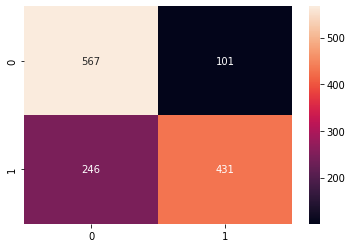

In [29]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='g')

### b - KNN

In [30]:
neigh = KNeighborsClassifier(n_neighbors=11)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [31]:
y_pred = neigh.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7405204460966542


In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75       668
           1       0.78      0.68      0.73       677

    accuracy                           0.74      1345
   macro avg       0.74      0.74      0.74      1345
weighted avg       0.74      0.74      0.74      1345



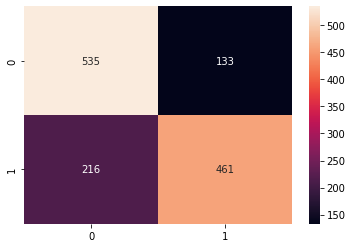

In [33]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='g')

### c - Naive Bayes

In [34]:
#BernoulliNB
#GaussianNB

In [35]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [36]:
y_pred = gnb.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6929368029739778


In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       668
           1       0.71      0.66      0.68       677

    accuracy                           0.69      1345
   macro avg       0.69      0.69      0.69      1345
weighted avg       0.69      0.69      0.69      1345



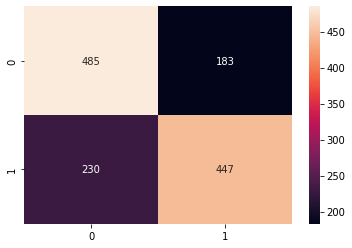

In [38]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='g')

In [39]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB()

In [40]:
y_pred = bnb.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6966542750929368


In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       668
           1       0.70      0.69      0.70       677

    accuracy                           0.70      1345
   macro avg       0.70      0.70      0.70      1345
weighted avg       0.70      0.70      0.70      1345



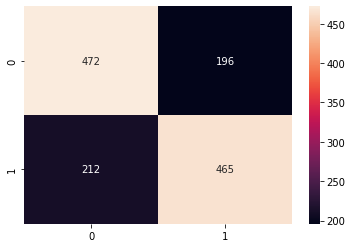

In [42]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='g')

### d- Deep Network

In [51]:
model = keras.Sequential(
    [
        keras.Input(shape=(12)),
        layers.Dense(8, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [52]:
model.compile(optimizer='adam',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])

In [53]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=20)

Epoch 1/50
103/103 [==============================] - 1s 4ms/step - loss: 0.7290 - accuracy: 0.5166 - val_loss: 0.6820 - val_accuracy: 0.5769
Epoch 2/50
103/103 [==============================] - 0s 2ms/step - loss: 0.6728 - accuracy: 0.6036 - val_loss: 0.6540 - val_accuracy: 0.6208
Epoch 3/50
103/103 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6442 - val_loss: 0.6287 - val_accuracy: 0.6779
Epoch 4/50
103/103 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6779 - val_loss: 0.6063 - val_accuracy: 0.6955
Epoch 5/50
103/103 [==============================] - 0s 2ms/step - loss: 0.5963 - accuracy: 0.6887 - val_loss: 0.5907 - val_accuracy: 0.6955
Epoch 6/50
103/103 [==============================] - 0s 2ms/step - loss: 0.5811 - accuracy: 0.7019 - val_loss: 0.5813 - val_accuracy: 0.7028
Epoch 7/50
103/103 [==============================] - 0s 2ms/step - loss: 0.5712 - accuracy: 0.7077 - val_loss: 0.5759 - val_accuracy: 0.6984
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


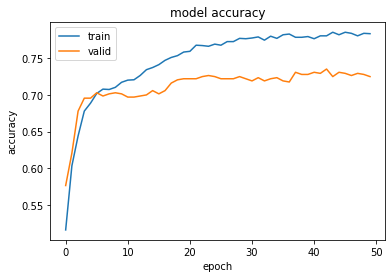

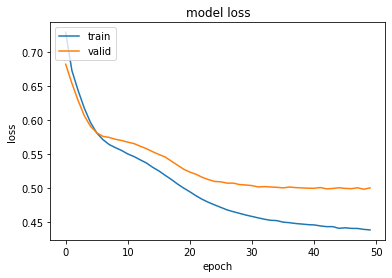

In [54]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **İSMAİL AVCU**